# Sentence Similarity Demo (Newa NLP)

This notebook demonstrates sentence embeddings and similarity for Newari text using the Hugging Face model `sundeepdwd/muril-mlm-newa-finetuned`.

Model card: https://huggingface.co/sundeepdwd/muril-mlm-newa-finetuned

It will:
- Load the model and tokenizer via `newa_nlp.SentenceEncoder`
- Sample sentences from `corpus.csv`
- Compute embeddings and cosine similarity
- Show top-k similar sentences for random queries
- Allow you to compare any two sentences interactively


In [2]:
# Install dependencies if needed (uncomment if running in a fresh env)
# !pip install transformers==4.56.1 torch pandas

import os
import random
import pandas as pd
import torch

from newa_nlp import SentenceEncoder, tokenize_sentences, top_k_similar, cosine_similarity

print(f"Torch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


Torch device: cuda


In [3]:
# Load encoder
encoder = SentenceEncoder()
encoder


Some weights of BertModel were not initialized from the model checkpoint at sundeepdwd/muril-mlm-newa-finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Sample sentences from corpus.csv

def sample_sentences_from_corpus(csv_path: str, sample_docs: int = 50, max_sentences: int = 200, min_len: int = 6):
    df = pd.read_csv(csv_path)
    assert 'content' in df.columns, "CSV must include 'content' column"
    if len(df) > sample_docs:
        df = df.sample(sample_docs, random_state=42)
    sents = []
    for content in df['content'].astype(str):
        for s in tokenize_sentences(content):
            if len(s.strip()) >= min_len:
                sents.append(s.strip())
                if len(sents) >= max_sentences:
                    break
        if len(sents) >= max_sentences:
            break
    return sents

if not os.path.exists('corpus.csv'):
    raise FileNotFoundError("corpus.csv not found in current directory")

sentences = sample_sentences_from_corpus('corpus.csv', sample_docs=80, max_sentences=200)
len(sentences)


200

In [5]:
# Encode and compute similarities for a few queries
embeddings = encoder.encode(sentences, batch_size=16)

# Pick 5 random queries from the set
import random
query_indices = random.sample(range(len(sentences)), k=min(5, len(sentences)))
queries = [sentences[i] for i in query_indices]
query_embs = embeddings[query_indices]

indices, scores = top_k_similar(query_embs, embeddings, k=10)

for qi, q_idx in enumerate(query_indices):
    print(f"Query {qi+1}: {sentences[q_idx]}")
    for rank, (idx, score) in enumerate(zip(indices[qi].tolist(), scores[qi].tolist()), start=1):
        print(f"  {rank}. ({score:.3f}) {sentences[idx]}")
    print()


Query 1: ल्ह्वक व फाक अप्व जुया तीब्र रुपं दिहाइद्रेसन, इलेक्त्रोलाइत इम्ब्यालेन्स, व मृत्यु जुइफु
  1. (1.000) ल्ह्वक व फाक अप्व जुया तीब्र रुपं दिहाइद्रेसन, इलेक्त्रोलाइत इम्ब्यालेन्स, व मृत्यु जुइफु
  2. (0.996) थ्व ल्वय्‌या प्राथमिक उपचार ओरल रिहाइद्रेसन थेरापी ख, गुकिलिं मनुया म्हय् लः व लवण (इलेक्त्रोलाइत)या मात्रा पूनर्स्थापित याइ
  3. (0.995) ल्वय्‌ सिक्क तःच्वसा वा याकनं सुधार यायेमाःसा इन्त्राभिनस फ्लुइद नं बी छिं
  4. (0.995) थ्व ल्वय् तःच्वया दिहाइद्रेसन जुया जलासें स्यंकी
  5. (0.995) कोलेरा इपिदिमियोलोजीइ सीकूगु दकलय् पुलांगु ल्वय्‌य् छता ल्वय् ख
  6. (0.994) ल्ह्वकफाक वा कोलेरा वा हैजा धाःगु ताःतूया कुचा स्मल इन्तेस्ताइनय् भिब्रियो कोलेरे ब्यायाक्तेरियाया संक्रमण ख
  7. (0.994) ल्वय्‌ सिक्क हे तःच्वसा ल्वय्‌या काल म्हो यायेत वा ल्वय्‌या प्रभाव म्हो यायेत एन्तिबायोतिक नं बि छिं
  8. (0.994) थ्व ल्वय्‌ संक्रमित खिया पदार्थ लः व नसाय् ल्वाकज्याना, अन्याःगु लः वा नसा, त्वना वा नया पुनिगु या
  9. (0.993) थ्व ल्वय्‌या मू लक्षण लःथें न्यागु फाक व ल्ह्वक ख
  10. (0.993) जाकी, तु

In [6]:
# Compare two custom sentences
s1 = "नेपाल भाषा नेवाः भाषा खः।"
s2 = "नेवाः भाषा नेपालया भाषा खः।"

emb = encoder.encode([s1, s2])
sim = cosine_similarity(emb[0:1], emb[1:2]).item()
print(f"Cosine similarity: {sim:.4f}")


Cosine similarity: 0.9991


In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

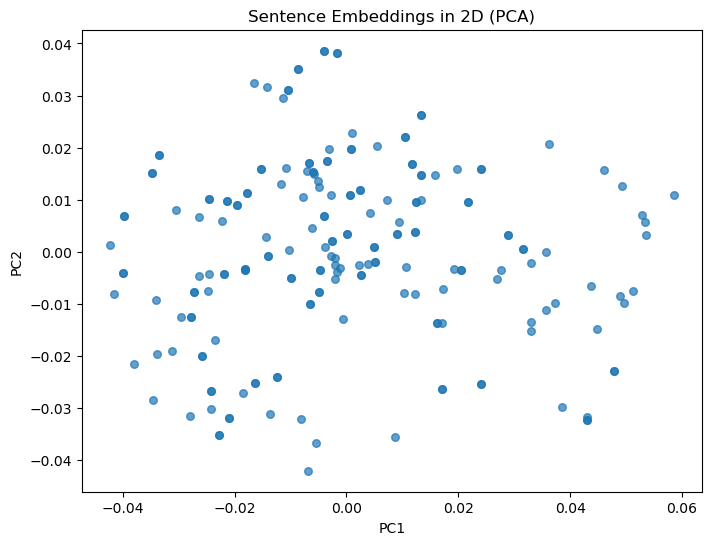

In [8]:
# embeddings is torch.Size([400, 768])
# if it's a torch tensor, convert to numpy
emb_np = embeddings.numpy() if hasattr(embeddings, "numpy") else embeddings

# reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(emb_np)  # shape: [400, 2]

# plot
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], s=30, alpha=0.7)
plt.title("Sentence Embeddings in 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


c:\Users\Nitro 5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Nitro 5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Nitro 5\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nitro 5\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

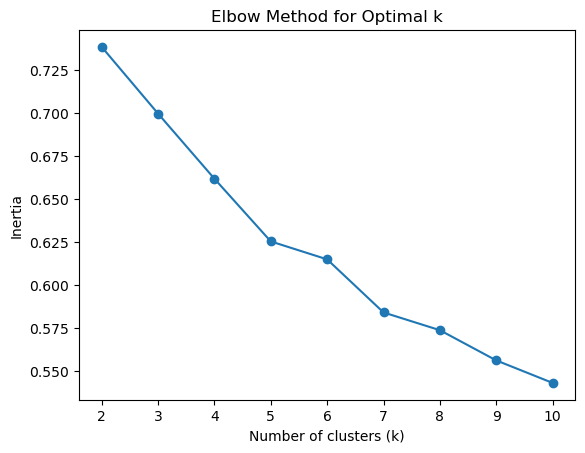

In [9]:
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    inertias.append(km.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

c:\Users\Nitro 5\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Nitro 5\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


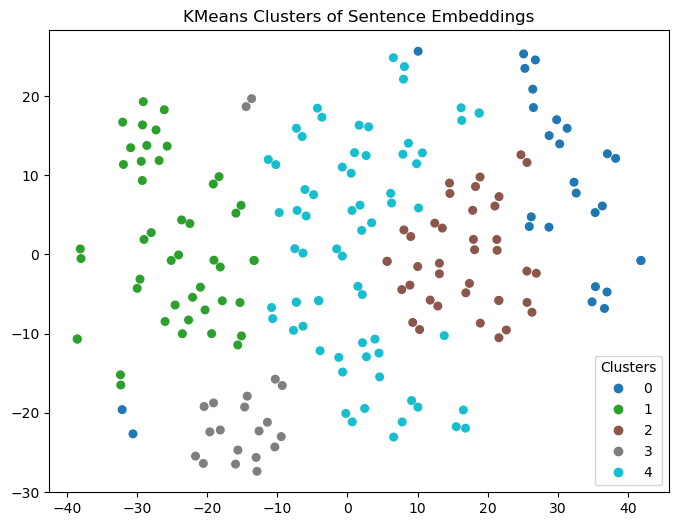

In [10]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(embeddings) 
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(embeddings)  # shape: [200, 2]
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced = tsne.fit_transform(embeddings)  # shape: [num_samples, 2]
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", s=30)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("KMeans Clusters of Sentence Embeddings")
plt.show()

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

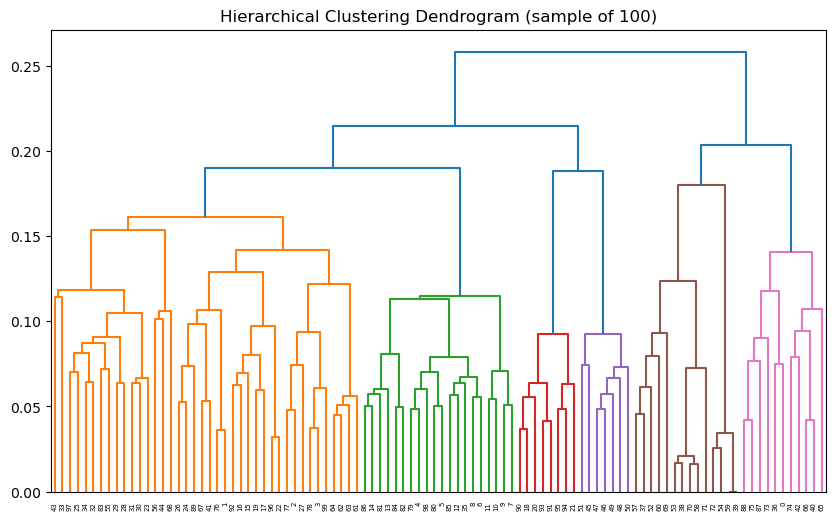

In [12]:
# linkage matrix for dendrogram
linked = linkage(embeddings[:100], method="ward")  # sample 100 points (otherwise too dense)

plt.figure(figsize=(10, 6))
dendrogram(linked,
           orientation="top",
           distance_sort="descending",
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (sample of 100)")
plt.show()

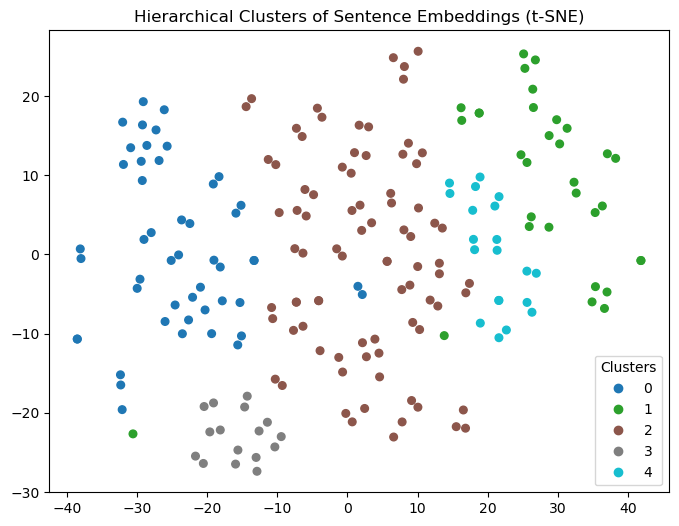

In [13]:
# Choose number of clusters, say 5
hclust = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage="ward")
labels = hclust.fit_predict(embeddings)
# reduce embeddings to 2D for plotting
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", s=30)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Hierarchical Clusters of Sentence Embeddings (t-SNE)")
plt.show()